## AIPI 590 - XAI | Assignment #7
### Explainable Deep Learning
#### Author: Tal Erez
#### Colab Notebook:
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/notthattal/ExplainableDeepLearning/blob/main/grad_cam.ipynb)

### To Run in Colab

Verify you are running on a GPU. On the top right of the screen click the down arrow in between "RAM/Disk" and "Gemini"  -> Change Runtime Type -> T4 GPU -> Save

*Note: Colab may throw an error after installing dependencies, but the notebook should still run. The error is due to the requirement of torch-cam requiring torch==2.5.0 but Colab requiring a torch version < 2.5.0, and other packages unrelated to this notebook (e.g. torchaudio).*

### Introduction
This notebook uses Grad-CAM to evaluate the ResNet50 pretrained model for each layer of the model. The images used come from a small version of the ImageNet library. For a given label, this will output the Grad-CAM overlayed images for each image of that label (or labels) in the dataset.

### Hypothesis Being Tested
$ H_0 $: Deeper layers of the ResNet50 model do not focus on more important and localized aspects of the image relating to the label being tested

$ H_1 $: The deeper layers of the ResNet50 model focuses on features of images more relating to the label being tested as opposed to shallower layers

### Approach
The approach used to test this hypothesis is to load in the TinyImageNet library and the pretrained ResNet50 model. We then assign a label to retrieve test images (in the case below we use the label 'wallaby' which contains 5 unique images of the animal), and for each layer of the model and for each of the images we run Grad-CAM and overlay the resulting Grad-CAM mask on top of the original image. Once complete, visual analysis of each image is performed to assess if Grad-CAM reports that deeper layers of the model focus on the important aspects of the image. For statistical analysis, we calculate the ratio of pixels in the heatmap produced by Grad-CAM that have a value > 0.85 and run the Kruskal-Wallis Test to calculate the p-value to determine if there's a statistical significance between the layers. The Kruskal-Wallis Test was chosen over Anova due to the ratio data violating the assumption of normality required by Anova.

### Install required dependencies and import packages

In [ ]:
import os

# Remove Colab default sample_data if it exists
if os.path.exists("./sample_data"):
    !rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "ExplainableDeepLearning"

# Check if the repo already exists
if not os.path.exists("/content/" + repo_name):
    git_path = 'https://github.com/notthattal/ExplainableDeepLearning.git'
    !git clone "{git_path}"
else:
    print(f"{repo_name} already exists.")

# Change working directory to location of notebook
path_to_notebook = os.path.join("/content/" + repo_name)
%cd "{path_to_notebook}"

!pip install -r requirements.txt

import json
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy.stats import kruskal
import torch
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image
from tqdm.notebook import tqdm
import urllib.request
from urllib.error import HTTPError
import zipfile

Cloning into 'ExplainableDeepLearning'...
remote: Enumerating objects: 537, done.
remote: Counting objects: 100% (537/537), done.
remote: Compressing objects: 100% (529/529), done.
remote: Total 537 (delta 8), reused 533 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (537/537), 18.72 MiB | 29.54 MiB/s, done.
Resolving deltas: 100% (8/8), done.
[Errno 2] No such file or directory: '/content/ExplainableDeepLearning'
/Users/talerez/Documents/AIPI_590_XAI/ExplainableDeepLearning


/Users/talerez/Documents/AIPI_590_XAI/ExplainableDeepLearning/venv/lib/python3.9/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


  Using cached matplotlib-3.7.1-cp39-cp39-macosx_11_0_arm64.whl (7.3 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.9.2
    Uninstalling matplotlib-3.9.2:
      Successfully uninstalled matplotlib-3.9.2
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 4.0.13
    Uninstalling widgetsnbextension-4.0.13:
      Successfully uninstalled widgetsnbextension-4.0.13
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 8.1.5
    Uninstalling ipywidgets-8.1.5:
      Successfully uninstalled ipywidgets-8.1.5

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


### Set The Device to be Used

In [2]:
device = None

# Fetching the device that will be used throughout this notebook
if torch.backends.mps.is_available():
    # Ensure that all operations are deterministic on GPU (if used) for reproducibility
    torch.use_deterministic_algorithms(True)

    #set device to use mps
    device = torch.device("mps")
elif torch.cuda.is_available():
    # Ensure that all operations are deterministic on GPU (if used) for reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    #set device to use cuda
    device = torch.device("cuda:0")
else:
    #set device to use the cpu
    device = torch.device("cpu")

print("Using device", device)

Using device mps


### Download the Dataset

In [13]:
# Github URL where the dataset is stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"

# Create paths if they don't exist yet
DATASET_PATH = "./data"
os.makedirs(DATASET_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
file_name = "TinyImageNet.zip"
file_path = os.path.join(DATASET_PATH, file_name)
if not os.path.isfile(file_path):
    file_url = base_url + file_name
    print(f"Downloading {file_url}...")
    try:
        urllib.request.urlretrieve(file_url, file_path)
    except HTTPError as e:
        print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)
    if file_name.endswith(".zip"):
        print("Unzipping file...")
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall(file_path.rsplit("/",1)[0])
            print("Unzip complete")

### Load the ResNet50 Model

In [4]:
# Load a pre-trained ResNet-34 model with ImageNet weights
pretrained_model = models.resnet50(weights='IMAGENET1K_V1')
pretrained_model = pretrained_model.to(device)

# Set model to evaluation mode
pretrained_model.eval()

# Specify that gradients are required for the network
for p in pretrained_model.parameters():
    p.requires_grad = True

### Load the Dataset, Label Names and Create the Folder Structure

In [5]:
# Load dataset and create data loader
imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
assert os.path.isdir(imagenet_path), f"Could not find the ImageNet dataset at expected path \"{imagenet_path}\". " + \
                                     f"Please make sure to have downloaded the ImageNet dataset here, or change the {DATASET_PATH=} variable."

# Load label names to interpret the label numbers 0 to 999
with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)

# get a list of folders in sorted order for retrieving pictures by label
folders = sorted([f for f in os.listdir(imagenet_path) if os.path.isdir(os.path.join(imagenet_path, f))])

### Create the Function to Get Images by Label

In [6]:
def get_images(label_name):
    '''
    gets a list of images in RGB format by label name from the TinyImageNet dataset

    Inputs:
        label_name: the label for which to retrieve the images

    Return:
        images: a list of the images retrieved
    '''
    #get the index of the label from label_list.json
    index = label_names.index(label_name)

    #get the corresponding folder of images from TinyImageNet
    folder = imagenet_path + folders[index] + '/'

    #get the images from the selected folder
    image_names = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

    images = []
    for image_name in image_names:
        #open the image
        with open(os.path.relpath(folder + image_name), 'rb') as f:
            with Image.open(f) as img:
                #convert the image to RGB and add it to the output list
                images.append(img.convert('RGB'))

    return images


### Create the Transforms

In [7]:
# Set the Mean and Std from ImageNet
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])

# Convert the input image to PyTorch Tensor, normalize the images using the mean and standard deviation above and
plain_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=NORM_MEAN,
                             std=NORM_STD)
    ])

# Resize and take the center part of image to what our model expects
pil_transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])

#combine the transforms to transform the final input tensors
combined_transforms = transforms.Compose([
    pil_transf,
    plain_transforms
])

### Create Function to Calculate Heatmap Pixel Ratio

In [8]:
def calculate_high_attribution_ratio(activation_map, threshold=0.85):
    """
    Calculate the ratio of pixels with attribution > threshold.

    Inputs:
    - activation_map: The Grad-CAM activation map
    - threshold: The threshold value for high attribution

    Returns:
    - The ratio of pixels with attribution > threshold inside the bounding box.
    """
    # apply the threshold to find the high-attribution pixels
    high_attribution_pixels = activation_map > threshold

    # count the total number of high-attribution pixels
    total_high_attribution_pixels = high_attribution_pixels.sum().item()

    # calculate the total number of pixels in the image
    total_pixels = activation_map.numel()

    # Calculate the ratio
    if total_pixels == 0:
        return 0
    else:
        return total_high_attribution_pixels / total_pixels

### Run Grad-CAM and Plot the Images

In [9]:
def run_grad_cam(labels, layers, plot_img=False):
    """
    Runs Grad-CAM for all images for each label in labels and for all layers in layers

    Inputs:
    - labels: The list of labels to test
    - layers: The list of strings corresponding to which layer to run
    - plot_img: A flag to decide whether or not to plot the images

    Returns:
    - ratios: a list of lists where each row is the ratio of pixels in the heatmap with a value > 0.85 and each column corresponds to a layer 
    """
    # create the return list of lists
    ratios = [[] for _ in range(len(layers))]
    for label in tqdm(labels, desc="Running GradCAM"):
        # get the all images for each label
        images = get_images(label)

        for i, layer_name in enumerate(layers):
            #get the target layer
            target_layer = getattr(pretrained_model, layer_name)
            
            # create the subplot for the images to be displayed
            if plot_img:
                _, axs = plt.subplots(1, len(images), figsize=(20, 5))

            # run Grad-CAM on the model for the target layer
            with GradCAM(pretrained_model, target_layer=target_layer) as cam_extractor:
                # run Grad-CAM on each image
                ratio_values = []
                for j, img in enumerate(images):
                    #transform the image into an input tensore
                    input_tensor = combined_transforms(img).unsqueeze(0).to(device)

                    # run the pretrained model over the tensor
                    out = pretrained_model(input_tensor)

                    # get the activation map
                    activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

                    # calculate the ratio of pixels in the heatmap with a value > 0.85
                    ratio_values.append(calculate_high_attribution_ratio(activation_map[0].squeeze(0)))

                    if plot_img:
                        # overlay the image with the results from Grad-CAM
                        result = overlay_mask(img, to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)

                        # plot the image
                        axs[j].imshow(result)
                        axs[j].axis('off')
                        axs[j].set_title(f'image {j + 1}', fontsize=20)

                if plot_img:
                    # create a side-by-side plot of images for each layer   
                    plt.suptitle(f"Grad-CAM Results For {label} at Layer: {i+1}", fontsize=30)
                    plt.tight_layout()
                    plt.show()
            
            # add the ratios to the layer
            ratios[i] = ratios[i] + ratio_values 
    return ratios


### Run Grad-CAM on One Label And Plot The Heatmaps

Running GradCAM:   0%|          | 0/1 [00:00<?, ?it/s]

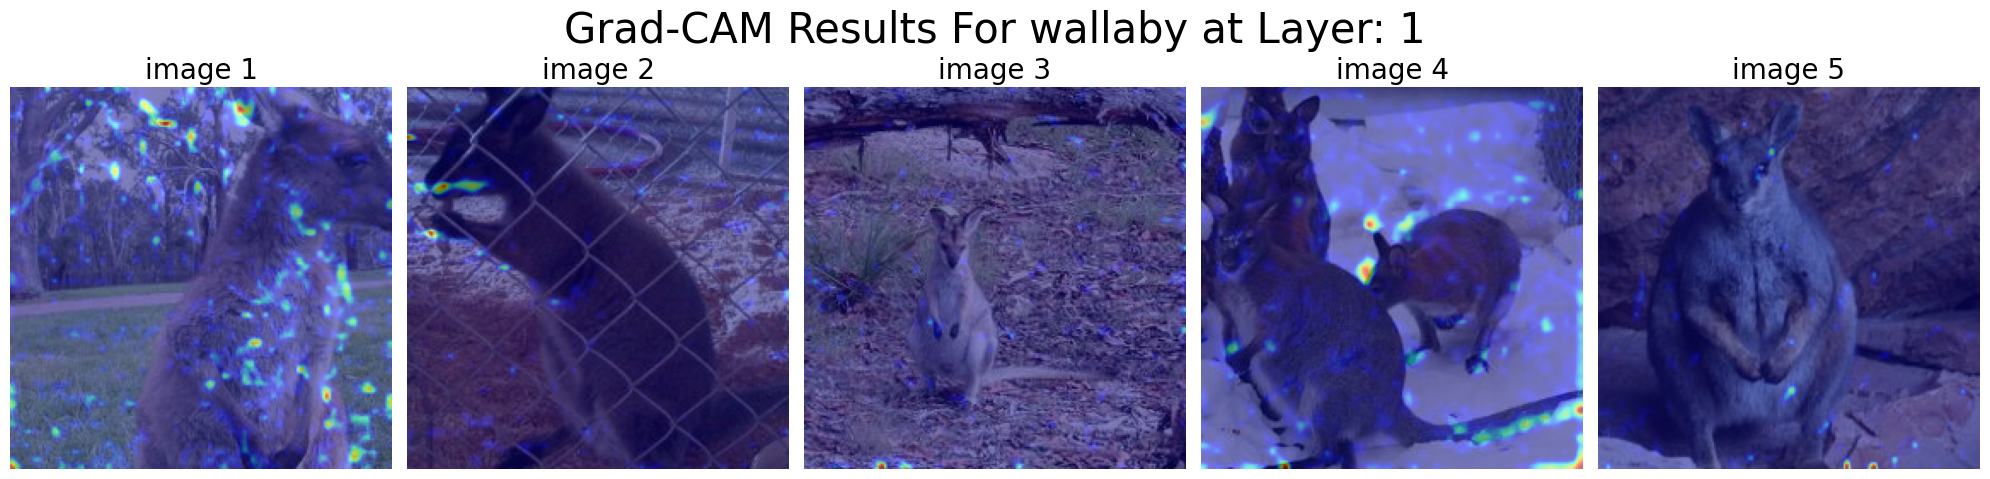

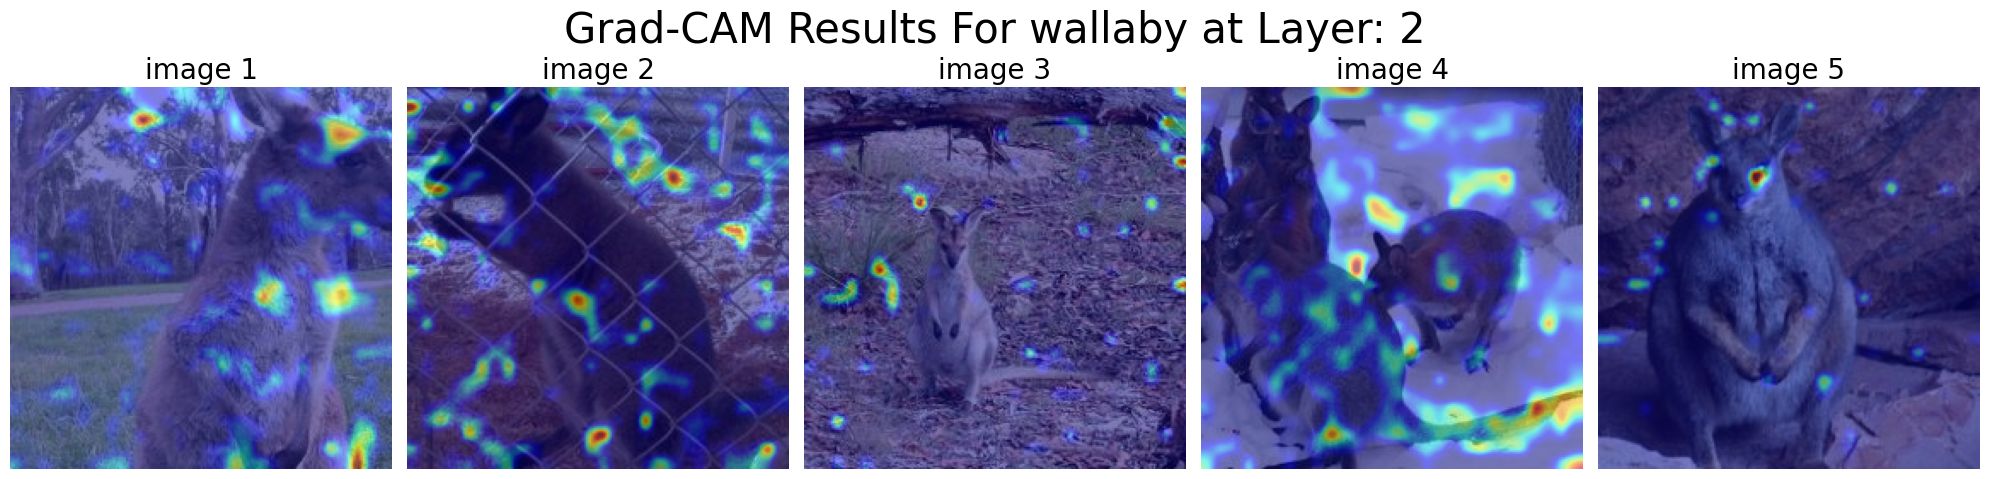

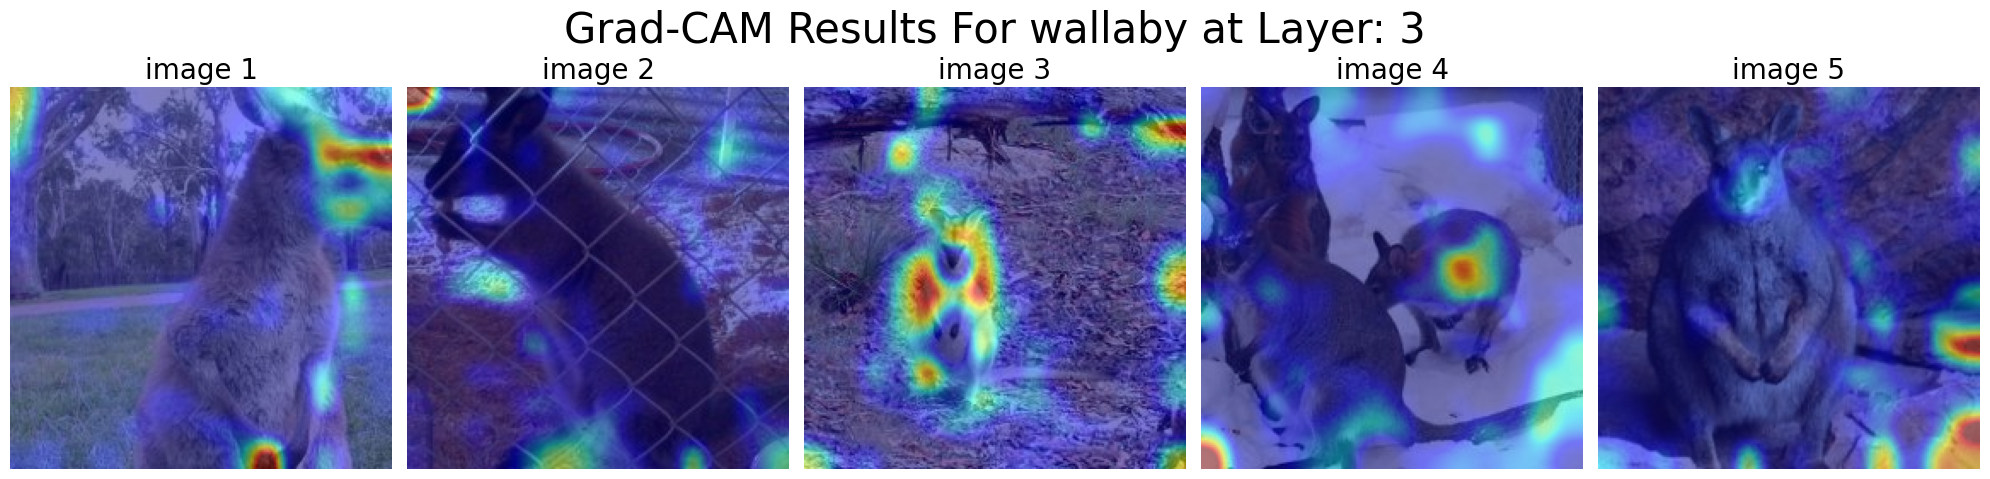

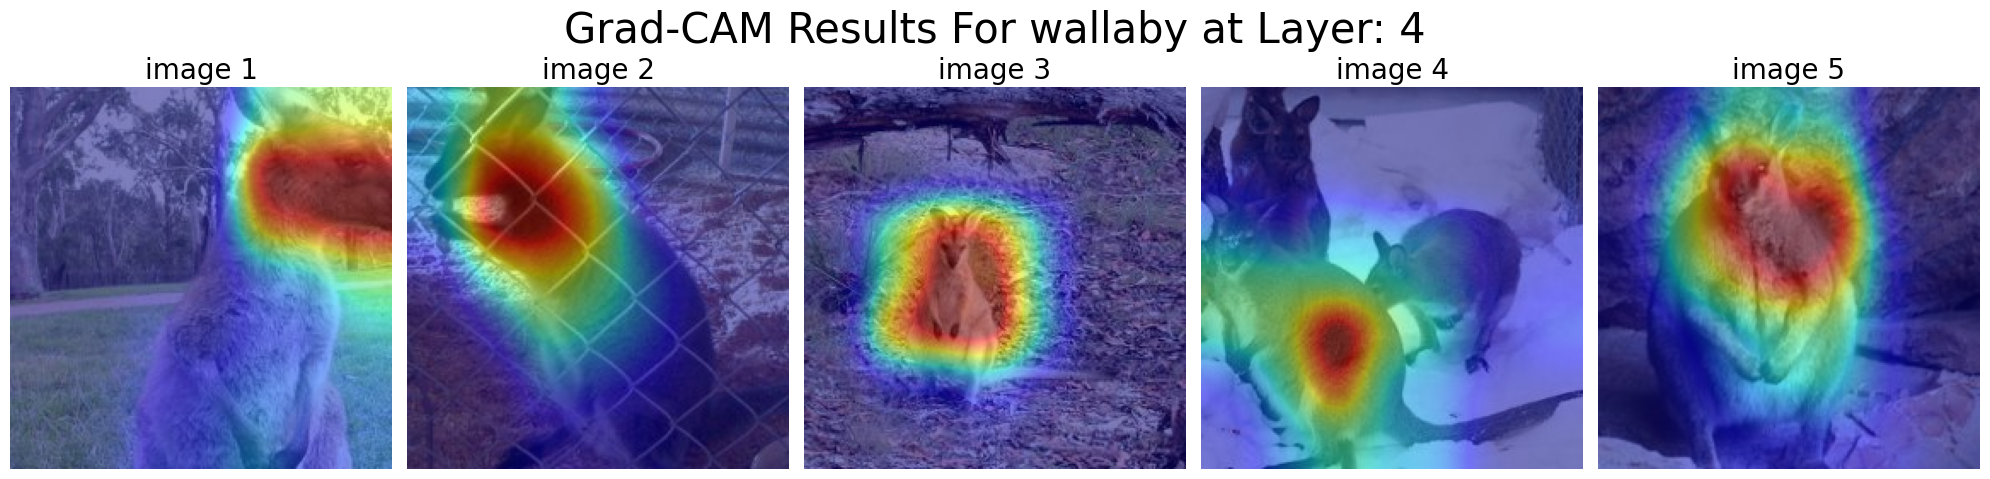

In [10]:
# assign the labels to be used for testing
labels_to_use = ['wallaby']

# assign the layers to be used for testing
layers = ['layer1', 'layer2', 'layer3', 'layer4']

ratios = run_grad_cam(labels_to_use, layers, True)

### Run Grad-CAM Over Multiple Instances For Statistical Analysis
*Note: This cell may take a minute to run*

In [11]:
ratios = run_grad_cam(label_names[:100], layers)

Running GradCAM:   0%|          | 0/100 [00:00<?, ?it/s]

### Calculate Statistical Results

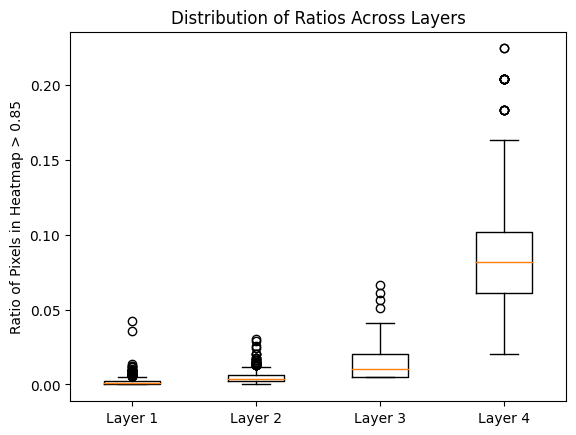

In [12]:
plt.boxplot(ratios)
plt.xticks([1, 2, 3, 4], ['Layer 1', 'Layer 2', 'Layer 3', 'Layer 4'])
plt.ylabel('Ratio of Pixels in Heatmap > 0.85')
plt.title('Distribution of Ratios Across Layers')
plt.show()


### Summary of Findings
- Layer 1: for this layer we can see that the heatmap is very sparse, randomly scattered amongst the image as a whole and rarely contains any yellow or red regions. While in some images it is able to pick up on features relating to the animal (such as the tail in image 4), the layer tends to also pick up noise in the background.
- Layer 2: For this layer, we can see that the model is still picking up noise from the background, but the heatmap has become stronger (showing more red regions than the previous layer). The heatmap also shows more regions relating to the face and body of the animal being highlighted, and for some images the mask looks almost like an outline of the animal. 
- Layer 3: In this layer the heatmap begins to become more localized. We can see for image one it's able to focus on the face and a section of the body, image 3 highlights the wallaby itself and image 4 highlights the centered animal. However, image 2 and 5 still focus mainly on the background and the other images still highlight noise as well.
- Layer 4: This layer shows the most localized results. All images have the heatmap centered on the animal itself. Image 1, 2 and 5 focus mainly on the facial regions of the animal. Image 3 highlights the wallaby as a whole, and image 4 focuses on the closest wallaby which takes up most of the image.
- Inspection of the box plots shows a general increase in pixel ratios with values > 0.85 in the heatmap for deeper layers which validates the alternative hypothesis. 
- Results: It is clear visually that the deeper layers of the ResNet50 model do in fact focus on more important features of the images. Thus we reject the null hypothesis.

### Citations:

*Dataset and Pre-Trained Model Set up:*
- Lippe, Phillip, & Bent, Brinnae, PhD "Tutorial 10: Adversarial attacks." Github, 2024, https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/explainable-ml-example-notebooks/local_explanations.ipynb

*Grad-CAM set up*
- [Stergiou, Alex](https://github.com/alexandrosstergiou) et. al "TorchCAM: class activation explorer." Github, 2019, https://github.com/frgfm/torch-cam

*Statistical Analysis for Grad-CAM*
- Nagy, Rajmund et. al "Analysis and Evaluation of Grad-CAM Explanations." KTH Royal Institute of Technology, n.d., https://raw.githubusercontent.com/ddnimara/DD2412-Project-Grad-CAM/main/Grad-CAM%20Explanation%20Analysis.pdf